In [531]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

In [688]:
class LinearLayer:
    # A linear layer of shape (d_in × d_out) with (tp_in × tp_out)-degree tensor
    # parallelism, dp-degree data parallelism, and bytewidth precision.
    def __init__(self, d_in, d_out, tp_in, tp_out, dp, bytewidth):
        self.d_in = d_in
        self.d_out = d_out
        self.tp_in = tp_in
        self.tp_out = tp_out
        self.dp = dp
        self.bytewidth = bytewidth

        # Derived dimensions.
        self.N = d_in*d_out                             # number of parameters
        self.d_in_local = d_in/tp_in                    # local input dimension
        self.d_out_local = d_out/tp_out                 # local output dimension
        self.N_local = self.d_in_local*self.d_out_local # local number of parameters

class ChinchillaOptimalModel:
    def __init__(self, training_flop, hidden_factor=5, bytewidth=2):
        self.training_flop = training_flop
        self.bytewidth = bytewidth
        self.hidden_factor = hidden_factor
        self.N = sqrt(training_flop/120)               # number of parameters
        self.D = 20*self.N                                # number of training tokens
        self.B = 2048*2048 * (training_flop/1e25)**(1/6)  # batch size, based on reciprocal of reducible loss
        self.L = 120 * (training_flop/1e25)**(1/6)        # number of residual blocks
        self.d = sqrt(self.N/(2*hidden_factor*self.L)) # residual dimension

class Parallelism:
    def __init__(self, pp, dp, tp_hidden, tp_residual, n_microbatches_per_batch):
        self.pp = pp
        self.dp = dp
        self.tp_hidden = tp_hidden
        self.tp_residual = tp_residual
        self.n_microbatches_per_batch = n_microbatches_per_batch

        self.n_devices = pp*dp*tp_hidden*tp_residual
    
    def __getitem__(self, key):
        return Parallelism(self.pp[key], self.dp[key], self.tp_hidden[key], self.tp_residual[key], self.n_microbatches_per_batch[key])

class Device:
    def __init__(self, name, flop_per_sec_8bit, global_Bps, net_Bps,
                 base_util=0.8, network_reduction=True, max_n_devices=15e6):
        self.name = name
        self.flop_per_sec_8bit = flop_per_sec_8bit
        self.global_Bps = global_Bps
        self.net_Bps = net_Bps
        self.base_util = base_util
        self.network_reduction = network_reduction
        self.max_n_devices = max_n_devices

    def __repr__(self):
        return self.name
    
    def all_reduce_communication(self, n, p):
        # The number of words this device has to send or receive to participate
        # in an all-reduce of a vector of local size n, with p - 1 other
        # devices.
        if self.network_reduction:
            # If p > 1, in this case a device on the network fabric does the
            # actual reduction and broadcast and we only need to transmit and
            # receive n words.
            #
            # We use a smooth underestimate of this: 2(p-1)n/p.
            return 2*n*(1 - 1/p)
            # return 2*(p - 1)*n/p
            # return (p > 1)*(2*n)
        else:
            # In this case we assume a bandwidth-optimal reduce-scatter +
            # multicast communication pattern, where each device is responsible
            # for reducing n/p words:
            #
            #  Step 1. Transmit p - 1 parts of size n/p to the devices
            #          responsible for reducing those parts.
            #
            #  Step 2. Receive p - 1 copies of the part of size n/p that I'm
            #          responsible for reducing from my peers.
            #
            #  Step 3. Reduce the p copies of my part and multicast the result
            #          to my peers (optimistically assumed to be free for
            #          simplicity).
            #
            #  Step 4. Receive p - 1 parts of size n/p that my peers were
            #          responsible for reducing.
            return 3*(p - 1)*n/p

    def linear_layer_fwd_bwd_secs(self, lin_layer, b):
        # Determine the time to compute a forward and backward pass through
        # lin_layer on a microbatch of b tokens. We take into account the time
        # of tensor FLOP, global memory IO, and tensor-parallel all-reduce
        # communication.
        #
        # Some assumptions (all "optimistic"):
        #  - Data movement and computation are fully overlappable, via the
        #    mechanism of multiple microbatches simultaneously in flight.
        #
        #  - Pipeline-parallel communication time is negligible (though deep
        #    pipelines may cause a bubble, which is modeled elsewhere).
        #
        #  - Pointwise operations such as activation functions and
        #    normalizations are negligible. So is attention and any
        #    communication it requires.
        #
        #  - b/dp is substantially smaller than d_in/tp_in and d_out/tp_out,
        #    where dp is the data parallel degree, tp_in is the input tensor
        #    parallel degree, and tp_out is the output tensor parallel degree.
        #    This is because this tends to be communication-optimal due to the
        #    significant communication costs of tensor parallelism compared to
        #    data parallelism. This in turn has a few implications:
        #
        #     1. The input and output matrix tends to be quite rectangular,
        #        which puts the on-chip data movement bottleneck at global
        #        memory rather than shared memory banks, L2 cache, or the
        #        SM-to-SM DSMEM network. This is because the SM- and warp-level
        #        tiles can still be large and approximately square-shaped, which
        #        removes these levels of the memory hierarchy as a bottleneck,
        #        however there isn't freedom to do this at the global level.
        #        Thus we do not model data movement on-chip except to/from
        #        global memory.
        #
        #     2. We treat global memory IO of activations as negligible. (We
        #        also assume activations fit in global memory and don't need to
        #        be recomputed during the backward pass.) However, we assume
        #        weights and their gradients cannot fit in L2 cache, such that
        #        global memory IO is required each time they're accessed.
        #
        #  - The all-reduce communication pattern is a bandwidth-optimal
        #    reduce-scatter followed by a multicast, and we treat the multicast
        #    transmission as free for simplicity.
        #
        # We also don't worry about whether our parallelism degrees divide the
        # tensor dimensions.
        d_in_local, d_out_local = lin_layer.d_in_local, lin_layer.d_out_local
        N_local = lin_layer.N_local
        tp_in, tp_out, dp = lin_layer.tp_in, lin_layer.tp_out, lin_layer.dp
        bytewidth = lin_layer.bytewidth
        b_local = b/dp

        flop, global_io, net_io = 0, 0, 0

        # Forward pass.
        global_io += N_local                                                   # Read weights.
        flop      += 2*N_local*b_local                                         # Compute output activations: Y = WX.
        net_io    += self.all_reduce_communication(d_out_local*b_local, tp_in) # All-reduce activations.

        # Backward pass (weight gradients).
        flop      += 2*N_local*b_local                                         # Compute weight gradients: ∂L/∂W = (∂L/∂Y)X^T.
        global_io += 2*N_local                                                 # Accumulate weight gradients (read + write).
        # Note: On the gradient accumulation step for the first microbatch,
        # we're overcounting global IO because technically there's no read
        # required. This is made up for by our ignoring of activation global IO
        # (e.g. during all-reduce or reloading in the backward pass), which
        # *across the whole batch* is greater than a single weight gradient
        # read. (It's also "optimistic" to distribute this cost evenly across
        # all the microbatches, since that provides better overlapping
        # opportunities.)
    
        # Backward pass (activation gradients).
        global_io += N_local                                                   # Read weights.
        flop      += 2*N_local*b_local                                         # Compute input gradients: ∂L/∂X = W^T(∂L/∂Y).
        net_io    += self.all_reduce_communication(d_in_local*b_local, tp_out) # All-reduce input gradients.

        # Total time for each type of operation. (base_util due to thermal
        # throttling is presumed to affect FLOP/s and global memory B/s, but not
        # net B/s).
        flop_secs = (flop*bytewidth)/(self.base_util*self.flop_per_sec_8bit)
        global_io_secs = (global_io*bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (net_io*bytewidth)/self.net_Bps
        return make_array(flop_secs, global_io_secs, net_io_secs)

    def linear_layer_end_of_batch_secs(self, lin_layer):
        # Determine the time for the end-of-batch gradient all-reduce (we assume
        # the optimizer step itself is negligible).
        io = self.all_reduce_communication(lin_layer.N_local, lin_layer.dp)
        global_io_secs = (io*lin_layer.bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (io*lin_layer.bytewidth)/self.net_Bps
        flop_secs = zeros_like(global_io_secs)
        return make_array(flop_secs, global_io_secs, net_io_secs)

    def model_batch_secs(self, model, parallelism):
        # Determine the time to train on a single batch of the given model,
        # given the provided parallelism degrees. We look at this from the
        # perspective of the first pipeline stage, which is the first to start
        # working and the last to finish.
    
        pp, dp, tp_hidden, tp_residual, n_microbatches_per_batch =\
            parallelism.pp, parallelism.dp, parallelism.tp_hidden, parallelism.tp_residual, parallelism.n_microbatches_per_batch
        feasible = (pp <= model.L) & (pp <= n_microbatches_per_batch)
        feasible &= (pp >= 1) & (dp >= 1) & (tp_hidden >= 1) & (tp_residual >= 1)
        residual_blocks_per_stage = model.L/pp
        linear_layers_per_stage = 2*residual_blocks_per_stage
    
        # Construct one of the linear layers for a residual block. We assume
        # combined forward+backward FLOP, global IO, and network IO is the same
        # for both layers across their forward and backward passes, which is
        # true as we're currently modeling it.
        lin_layer = LinearLayer(model.d, model.hidden_factor*model.d, tp_residual, tp_hidden, dp, model.bytewidth)

        # Determine the microbatch size and basic step times for a linear
        # layer's forward and backward pass on a single microbatch, as well as a
        # linear layer's data-parallel communication time. These are arrays of
        # the shape (3, *), where the first dimension is FLOP secs, global
        # memory IO secs, and network IO secs.
        b = model.B / n_microbatches_per_batch
        layer_microbatch_fwd_bwd_secs = self.linear_layer_fwd_bwd_secs(lin_layer, b)
        layer_dp_secs = self.linear_layer_end_of_batch_secs(lin_layer)
    
        # We assume the first layers's data-parallel communication can overlap
        # with the "boundary microbatch", defined as the backward pass of its
        # very last microbatch and the forward pass of its very first
        # microbatch. (The addition happens separately for each of the three
        # resources.)
        boundary_step_secs = layer_microbatch_fwd_bwd_secs + layer_dp_secs

        # For each of the rest of the layers handled by the first pipeline
        # stage, we assume its data-parallel communication can overlap with that
        # stage's *previous* layer's non-boundary microbatches, plus the current
        # layer's own boundary microbatch.
        sustained_dp_layers = linear_layers_per_stage - 1
        sustained_dp_secs = sustained_dp_layers*(n_microbatches_per_batch*layer_microbatch_fwd_bwd_secs + layer_dp_secs)

        # This leaves some microbatches on the first pipeline stage's last layer
        # which can't overlap with data-parallel communication.
        sustained_no_dp_steps = n_microbatches_per_batch - 1
        sustained_no_dp_secs = sustained_no_dp_steps*layer_microbatch_fwd_bwd_secs
    
        # Finally, we have some "bubble" steps when the first pipeline stage is
        # just idle but later stages are still working. Since we optimistically
        # treat pipeline-parallel communication as free, we assume maximal
        # pipeline stage interleaving of the residual blocks, so that this
        # occurs for a length of time corresponding to pp - 1 residual blocks,
        # i.e. 2(pp - 1) linear layer steps.
        pipeline_bubble_steps = 2*(pp - 1)
        pipeline_bubble_secs = pipeline_bubble_steps*layer_microbatch_fwd_bwd_secs

        # For each stage of the batch, we take the max of FLOP time, global
        # memory IO time, and network IO time.
        return boundary_step_secs.max(axis=0) + sustained_dp_secs.max(axis=0) +\
            sustained_no_dp_secs.max(axis=0) + pipeline_bubble_secs.max(axis=0) +\
            mult(~feasible, np.inf),\
            (boundary_step_secs, sustained_dp_secs, sustained_no_dp_secs, pipeline_bubble_secs)

    def model_train_secs(self, model, parallelism):
        num_batches = model.D/model.B
        batch_secs, _ = self.model_batch_secs(model, parallelism)
        return num_batches*batch_secs

In [576]:
granularity = 0.01
def add_next_parallelism(device, model, par):
    par_last = par[-1]

    # Consider doubling each of the four parallelism degrees.
    pars = (np.ones((4, 4)) + granularity*np.diag([1, 1, 1, 1]))*[par_last.pp, par_last.dp, par_last.tp_hidden, par_last.tp_residual]

    # For each parallelism configuration, consider all power of 2 microbatch
    # counts between 1 and 2^22.
    idx_par, idx_mb = [x.flatten() for x in np.meshgrid(np.arange(4), np.arange(0, 23, granularity))]
    pp, dp, tp_hidden, tp_residual = pars[idx_par].T
    n_microbatches_per_batch = 2**idx_mb

    # Filter out invalid parallelism degrees.
    valid = (pp <= model.L) & (pp <= n_microbatches_per_batch)
    par2 = Parallelism(pp[valid], dp[valid], tp_hidden[valid], tp_residual[valid], n_microbatches_per_batch[valid])

    # Find the best by total training time.
    train_secs = device.model_train_secs(model, par2)
    best_idx = np.argmin(train_secs)
    # Add the best parallelism degree.
    return Parallelism(np.append(par.pp, par2.pp[best_idx]),
                       np.append(par.dp, par2.dp[best_idx]),
                       np.append(par.tp_hidden, par2.tp_hidden[best_idx]),
                       np.append(par.tp_residual, par2.tp_residual[best_idx]),
                       np.append(par.n_microbatches_per_batch, par2.n_microbatches_per_batch[best_idx]))

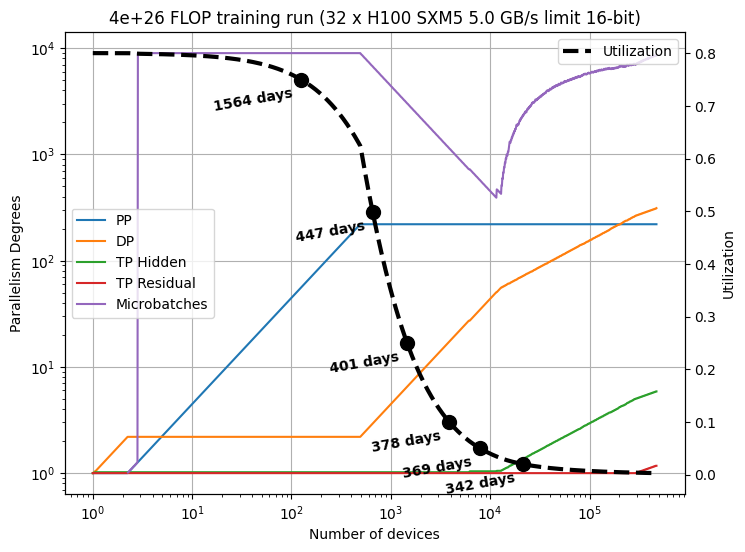

In [690]:
a100 = Device('A100', 623.7e12, 1555e9, 600e9)
h100 = Device('H100 SXM5', 1979e12, 3352e9, 900e9)

bw_limit = 5e9
pod_size = 32
h100_pod = Device(f'{pod_size} x H100 SXM5 {bw_limit/1e9:.1f} GB/s limit',
                  pod_size*h100.flop_per_sec_8bit,
                  pod_size*h100.global_Bps,
                  bw_limit,
                  max_n_devices=15e6/pod_size)
device = h100_pod
model = ChinchillaOptimalModel(4e26)

par = Parallelism(*np.array([1, 1, 1, 1, 1]).reshape(-1, 1))

for i in np.arange(np.log2(device.max_n_devices/par.n_devices[0])/np.log2(1 + granularity)):
    par = add_next_parallelism(device, model, par)

theoretical_flop_per_sec = par.n_devices*device.flop_per_sec_8bit/model.bytewidth
training_secs = device.model_train_secs(model, par)
actual_flop_per_sec = model.training_flop/training_secs
util = actual_flop_per_sec/theoretical_flop_per_sec

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'{model.training_flop} FLOP training run ({device.name} {model.bytewidth*8}-bit)')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Parallelism Degrees')
ax.plot(par.n_devices, par.pp, label='PP')
ax.plot(par.n_devices, par.dp, label='DP')
ax.plot(par.n_devices, par.tp_hidden, label='TP Hidden')
ax.plot(par.n_devices, par.tp_residual, label='TP Residual')
ax.plot(par.n_devices[par.pp > 1], par.n_microbatches_per_batch[par.pp > 1], label='Microbatches')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Utilization')
ax2.plot(par.n_devices, util, label='Utilization', color='black', linestyle='--', linewidth=3)
idxs = []
training_days = training_secs/86400
for u in [0.75, 0.5, 0.25, 0.1, 0.05, 0.02]:
    i = np.argmin(np.abs(util - u))
    idxs.append(i)
    ax2.annotate(f'{int(np.round(training_days[i]))} days', (par.n_devices[i], util[i]), xytext=(-5, -5),
                 textcoords='offset points', ha='right', va='top', rotation=10, fontsize=10, weight='bold')
    if np.all(util > u):
        break
ax2.plot(par.n_devices[idxs], util[idxs], 'o', color='black', markersize=10)
ax.legend(loc='center left')
ax2.legend()

ax.grid()

In [732]:
def ensure_interval_array(obj):
    if isinstance(obj, IntervalArray):
        return obj
    else:
        return IntervalArray(obj, obj)

def mult(x, y):
    if isinstance(x, IntervalArray) or isinstance(y, IntervalArray):
        return x*y
    else:
        return np_mult_with_0_inf(x, y)

def np_mult_with_0_inf(x, y):
    """Multiply two numpy arrays, treating 0*inf as 0."""
    if x.shape == () and y.shape == ():
        if (x == 0 and np.isinf(y)) or (y == 0 and np.isinf(x)):
            return 0
        else:
            return x*y
    with np.errstate(invalid='ignore'):
        prod = x*y
    prod[((x == 0) & np.isinf(y)) | ((y == 0) & np.isinf(x))] = 0
    return prod

class IntervalArray:
    """This class represents an array of closed intervals, allowing interval
    arithmetic in a numpy-like manner. For some continuous functions, it can be
    used to efficiently find a point taking on a value provably close to the
    function's minimum, even when it is nonconvex and analytically difficult."""
    def __init__(self, low, high):
        assert np.all(low <= high)
        self.low = np.array(low)
        self.high = np.array(high)
    
    def __repr__(self):
        return f'IntervalArray(low: {self.low}, high: {self.high})'

    # Addition and Subtraction
    def __add__(self, other):
        other = ensure_interval_array(other)
        return IntervalArray(self.low + other.low, self.high + other.high)
    def __radd__(self, other):
        return self + other
    def __neg__(self):
        return IntervalArray(-self.high, -self.low)
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other

    # Multiplication and Division
    def __mul__(self, other):
        # Have to consider all possible combinations of signs, ensuring 0*inf is
        # zero.
        other = ensure_interval_array(other)
        ll = np_mult_with_0_inf(self.low, other.low)
        lh = np_mult_with_0_inf(self.low, other.high)
        hl = np_mult_with_0_inf(self.high, other.low)
        hh = np_mult_with_0_inf(self.high, other.high)
        return IntervalArray(np.minimum(np.minimum(ll, lh), np.minimum(hl, hh)),
                             np.maximum(np.maximum(ll, lh), np.maximum(hl, hh)))
    def __rmul__(self, other):
        return self*other
    def reciprocal(self):
        # In the case low < 0 < high, the reciprocal is [-inf, inf].
        contains_zero_neighborhood = (self.low < 0) & (0 < self.high)
        return IntervalArray(np.where(contains_zero_neighborhood, -np.inf, 1/self.high),
                             np.where(contains_zero_neighborhood, np.inf, 1/self.low))
    def __truediv__(self, other):
        other = ensure_interval_array(other)
        return self*other.reciprocal()
    def __rtruediv__(self, other):
        other = ensure_interval_array(other)
        return other*self.reciprocal()

    # Exponentiation and Logarithms
    def exp(self):
        return IntervalArray(np.exp(self.low), np.exp(self.high))
    def log(self, tolerant=False):
        if tolerant:
            with np.errstate(invalid='ignore'):
                return IntervalArray(np.log(np.maximum(self.low, 0.0)), np.log(np.maximum(self.high, 0.0)))
        else:
            assert np.all(self.low >= 0)
            return IntervalArray(np.log(self.low), np.log(self.high))
    def __pow__(self, other):
        assert np.all(self.low >= 0)
        other = ensure_interval_array(other)
        return IntervalArray(np.minimum(self.low**other.low, self.low**other.high),
                             np.maximum(self.high**other.low, self.high**other.high))
    def __rpow__(self, other):
        other = ensure_interval_array(other)
        return other**self

    # Comparison
    def __lt__(self, other):
        other = ensure_interval_array(other)
        return IntervalArray(self.high < other.low, self.low < other.high)
    def __le__(self, other):
        other = ensure_interval_array(other)
        return IntervalArray(self.high <= other.low, self.low <= other.high)
    def __gt__(self, other):
        other = ensure_interval_array(other)
        return IntervalArray(self.low > other.high, self.high > other.low)
    def __ge__(self, other):
        other = ensure_interval_array(other)
        return IntervalArray(self.low >= other.high, self.high >= other.low)

    # Logical
    def assert_boolean(self):
        assert self.low.dtype == bool
        assert self.high.dtype == bool
    def __and__(self, other):
        other = ensure_interval_array(other)
        self.assert_boolean()
        other.assert_boolean()
        return IntervalArray(self.low & other.low, self.high & other.high)
    def __or__(self, other):
        other = ensure_interval_array(other)
        self.assert_boolean()
        other.assert_boolean()
        return IntervalArray(self.low | other.low, self.high | other.high)
    def __invert__(self):
        self.assert_boolean()
        return IntervalArray(~self.high, ~self.low)

    # Reduction
    def sum(self, axis=None):
        return IntervalArray(np.sum(self.low, axis=axis), np.sum(self.high, axis=axis))
    def max(self, axis=None):
        return IntervalArray(np.max(self.low, axis=axis), np.max(self.high, axis=axis))
    def min(self, axis=None):
        return IntervalArray(np.min(self.low, axis=axis), np.min(self.high, axis=axis))

    # Access
    def __getitem__(self, key):
        return IntervalArray(self.low[key], self.high[key])
    def __len__(self):
        assert len(self.low) == len(self.high)
        return len(self.low)

    # Concatenation
    def cat(self, other):
        return IntervalArray(np.concatenate([self.low, other.low]),
                             np.concatenate([self.high, other.high]))

    # Conversion
    def midpoint(self):
        return (self.low + self.high)/2

def zeros_like(obj):
    if isinstance(obj, IntervalArray):
        return IntervalArray(np.zeros_like(obj.low), np.zeros_like(obj.high))
    else:
        return np.zeros_like(obj)

def make_array(*args):
    """Makes a new array out of the arguments, preserving lows and highs."""
    low = []
    high = []
    any_interval_arrays = False
    for arg in args:
        if isinstance(arg, IntervalArray):
            low.append(arg.low)
            high.append(arg.high)
            any_interval_arrays = True
        else:
            low.append(arg)
            high.append(arg)
    if any_interval_arrays:
        low = np.array(np.broadcast_arrays(*low))
        high = np.array(np.broadcast_arrays(*high))
        return IntervalArray(low, high)
    else:
        return np.array(args)

def optimize_over_interval(f, *interval_arrays, tol=0.05, max_steps=1e7,
                           errtol=np.log(2)):
    length = None
    for interval_array in interval_arrays:
        if length is None:
            length = len(interval_array)
        else:
            assert len(interval_array) == length
    splitvar = 0
    iters, steps = 0, 0
    best_result = None
    best_high = np.inf
    while True:
        obj = f(*interval_arrays)
        iters += 1
        steps += len(interval_arrays[0])
        idx = obj.high.argmin()
        if obj.high[idx] < best_high:
            best_result = [x[idx] for x in interval_arrays]
            best_high = obj.high[idx]
        delta = best_high - obj.low.min()
        if delta <= tol or steps >= max_steps:
            if delta > errtol:
                print(f'WARNING: Optimization took {steps} steps in {iters} iterations, but the error is still {delta}.')
            else:
                print(f'Optimization took {steps} steps in {iters} iterations, with error {delta}.')
            return best_result, best_high

        idxs = obj.low < best_high - tol
        new_interval_arrays = []
        for i, ia in enumerate(interval_arrays):
            ia2 = ia[idxs]
            midpoint = (ia2.low + ia2.high)/2
            if i == splitvar:
                lowhalf = IntervalArray(ia2.low, midpoint)
                highhalf = IntervalArray(midpoint, ia2.high)
                new_interval_arrays.append(lowhalf.cat(highhalf))
            else:
                new_interval_arrays.append(ia2.cat(ia2))
        interval_arrays = new_interval_arrays

        splitvar = (splitvar + 1) % len(interval_arrays)

log2_n_devices = np.arange(1., 20, 0.2)
log2_pp = np.zeros_like(log2_n_devices)
log2_dp = np.zeros_like(log2_n_devices)
log2_n_tp_hidden = np.zeros_like(log2_n_devices)
log2_n_microbatches = np.zeros_like(log2_n_devices)
for k, i in enumerate(log2_n_devices):
    i = float(i)
    def f(log2_pp, log2_n_tp_hidden, log2_n_microbatches):
        secs = device.model_train_secs(model, Parallelism(2.**log2_pp, 2.**(i-log2_pp-log2_n_tp_hidden),
                                                          2.**log2_n_tp_hidden, 1.,
                                                          2.**log2_n_microbatches))
        return secs.log(tolerant=True)
    (l2pp, l2tph, l2mb), obj = optimize_over_interval(f,
                                                      IntervalArray([0.], [i-1]),
                                                      IntervalArray([0.], [8.]),
                                                      IntervalArray([0.], [20.]))
    # print(l2pp, l2mb, obj)
    log2_pp[k] = l2pp.low
    log2_n_tp_hidden[k] = l2tph.midpoint()
    log2_dp[k] = (i - log2_pp[k] - log2_n_tp_hidden[k])
    log2_n_microbatches[k] = l2mb.midpoint()
    # print(f'For {2**i} devices, PP={2.**log2_pp[k]}, DP={2.**log2_dp[k]}, microbatches={2.**log2_n_microbatches[k]}.')

Optimization took 7993715 steps in 31 iterations, with error 0.03790648643687078.
Optimization took 7199123 steps in 31 iterations, with error 0.03817763732891777.
Optimization took 6187189 steps in 31 iterations, with error 0.03844899028118931.
Optimization took 5217419 steps in 31 iterations, with error 0.03876133328006759.
Optimization took 4240595 steps in 31 iterations, with error 0.03952375500853478.
Optimization took 3374255 steps in 31 iterations, with error 0.03963231330549988.
Optimization took 2792395 steps in 31 iterations, with error 0.039495400258285684.
Optimization took 2365609 steps in 31 iterations, with error 0.039760540451148074.
Optimization took 2042385 steps in 31 iterations, with error 0.04002479882623078.
Optimization took 1790529 steps in 31 iterations, with error 0.040288037911931696.
Optimization took 1587897 steps in 31 iterations, with error 0.04055009902358009.
Optimization took 1422001 steps in 31 iterations, with error 0.040810799052483304.
Optimization

/var/folders/py/7mk4bf691yx4h91m65gbv_xm0000gn/T/ipykernel_97524/1933518297.py:82: RuntimeWarning: divide by zero encountered in log
  return IntervalArray(np.log(np.maximum(self.low, 0.0)), np.log(np.maximum(self.high, 0.0)))


Optimization took 20591 steps in 33 iterations, with error 0.04680607248571533.
Optimization took 18611 steps in 32 iterations, with error 0.049079502251700546.
Optimization took 16989 steps in 32 iterations, with error 0.04743521582482302.
Optimization took 15415 steps in 30 iterations, with error 0.048471174665660754.
Optimization took 14459 steps in 30 iterations, with error 0.044920581646646696.
Optimization took 13679 steps in 30 iterations, with error 0.04185676306475017.
Optimization took 12845 steps in 30 iterations, with error 0.03952642200140133.
Optimization took 12153 steps in 30 iterations, with error 0.048732345785307274.
Optimization took 11703 steps in 30 iterations, with error 0.045781110595243035.
Optimization took 11475 steps in 30 iterations, with error 0.04976131031224895.
Optimization took 11407 steps in 29 iterations, with error 0.04561896462245585.
Optimization took 11337 steps in 30 iterations, with error 0.04707724119531065.
Optimization took 11485 steps in 30

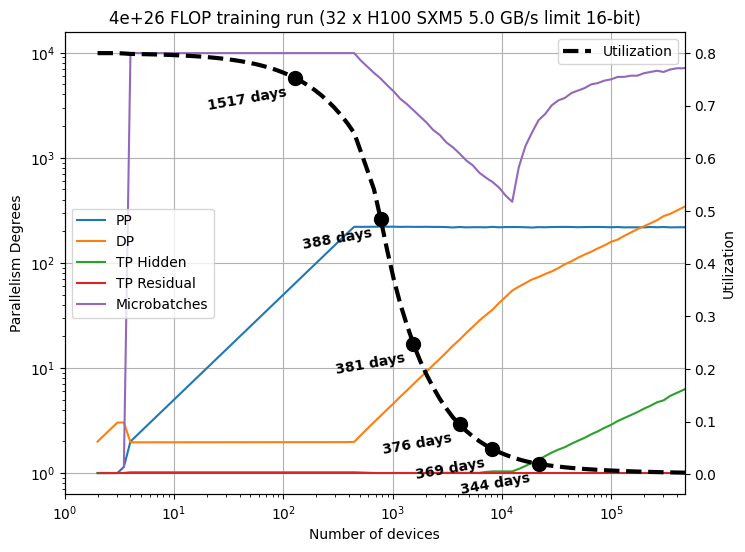

In [733]:
par = Parallelism(2.**log2_pp, 2.**log2_dp,
                  2.**log2_n_tp_hidden, np.ones_like(log2_n_devices),
                    2.**log2_n_microbatches)
theoretical_flop_per_sec = par.n_devices*device.flop_per_sec_8bit/model.bytewidth
training_secs = device.model_train_secs(model, par)
actual_flop_per_sec = model.training_flop/training_secs
util = actual_flop_per_sec/theoretical_flop_per_sec

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'{model.training_flop} FLOP training run ({device.name} {model.bytewidth*8}-bit)')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Parallelism Degrees')
ax.plot(par.n_devices, par.pp, label='PP')
ax.plot(par.n_devices, par.dp, label='DP')
ax.plot(par.n_devices, par.tp_hidden, label='TP Hidden')
ax.plot(par.n_devices, par.tp_residual, label='TP Residual')
ax.plot(par.n_devices[par.pp > 1], par.n_microbatches_per_batch[par.pp > 1], label='Microbatches')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Utilization')
ax2.plot(par.n_devices, util, label='Utilization', color='black', linestyle='--', linewidth=3)
idxs = []
training_days = training_secs/86400
for u in [0.75, 0.5, 0.25, 0.1, 0.05, 0.02]:
    i = np.argmin(np.abs(util - u))
    idxs.append(i)
    ax2.annotate(f'{int(np.round(training_days[i]))} days', (par.n_devices[i], util[i]), xytext=(-5, -5),
                 textcoords='offset points', ha='right', va='top', rotation=10, fontsize=10, weight='bold')
    if np.all(util > u):
        break
ax2.plot(par.n_devices[idxs], util[idxs], 'o', color='black', markersize=10)
ax.legend(loc='center left')
ax2.legend()
ax.set_xlim(1, device.max_n_devices)

ax.grid()


In [726]:
par.pp

array([  2.        ,   2.21164095,   2.54016441,   2.98137234,
         3.35085962,   3.84860588,   4.44609589,   5.07929725,
         5.83418547,   6.92210554,   7.69721176,   8.84057756,
        10.12769793,  11.69604789,  13.35995969,  15.34760257,
        17.67636841,  20.30206663,  23.63881708,  27.15019444,
        30.68481808,  35.62659778,  40.92421427,  46.86977414,
        53.45431013,  61.40079997,  70.91157421,  81.12036213,
        93.30906316, 107.08787774, 122.84316926, 140.99040019,
       162.13094041, 186.10564775, 213.87876099, 221.89709163,
       221.89380597, 221.89896917, 221.88723481, 221.88958163,
       221.890051  , 221.8980304 , 221.89380597, 221.90694888,
       221.87878645, 221.88535737, 221.89474473, 221.88770417,
       221.88254124, 221.89380597, 221.88535737, 221.88535737,
       221.87127708, 221.88958163, 221.86001349, 221.84781191,
       221.81496485, 221.85156617, 221.833734  , 221.84781191,
       221.81496485, 221.82059543, 221.83748802, 221.83

In [588]:
log2_pp

array([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  8,  9, 10,  8])

In [536]:
secs_per_batch = 1e7/(model.D/model.B)
secs_per_step = secs_per_batch/(2*2*model.L) # fwd + bwd, reduce + bcast
print(f'~{1e6*secs_per_step:.1f}µs per comms step')

~2393.0µs per comms step


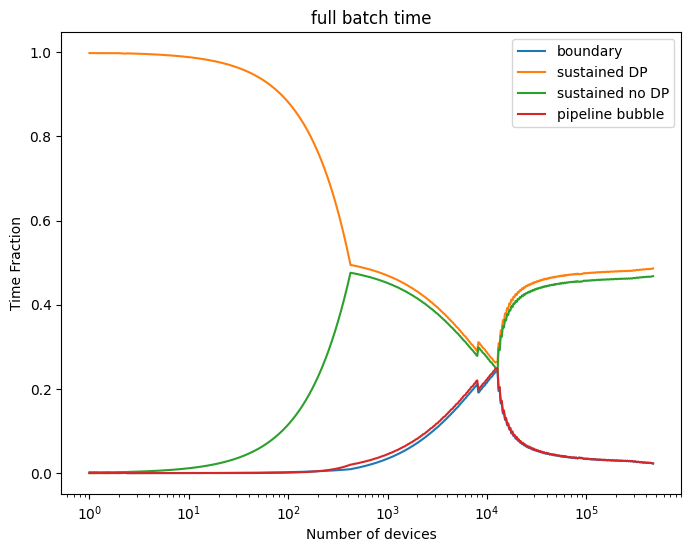

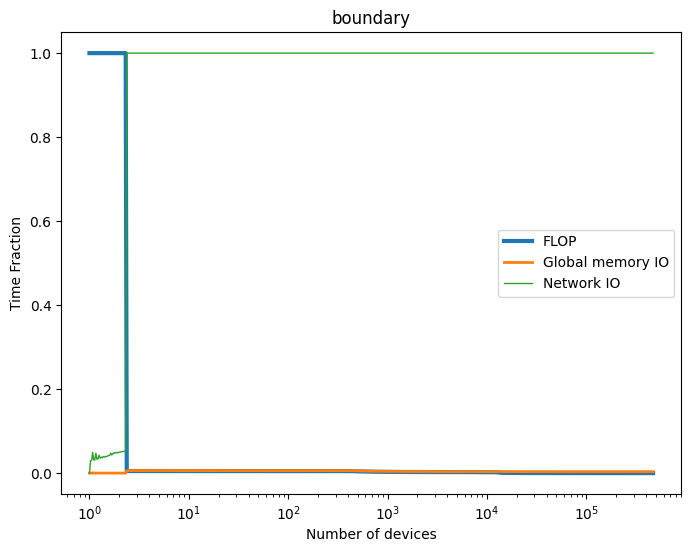

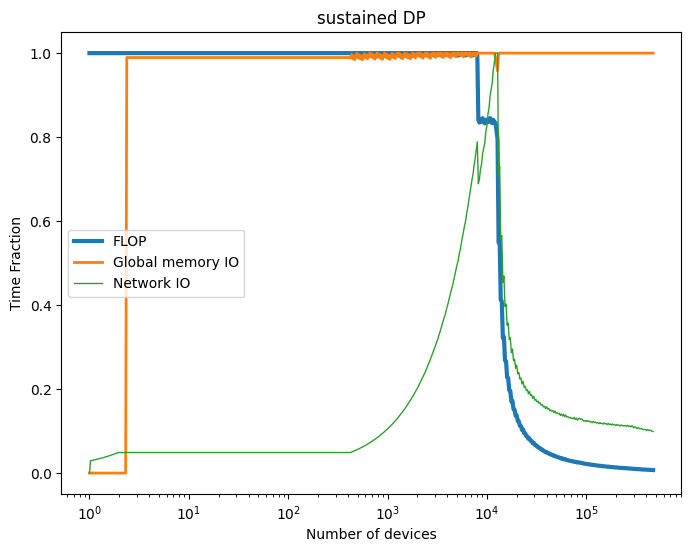

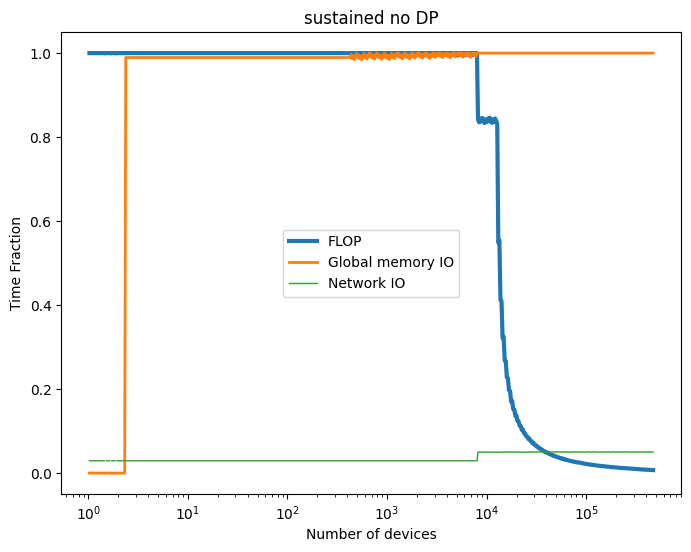

In [537]:
batch_secs, (boundary_step_secs, sustained_dp_secs, sustained_no_dp_secs, pipeline_bubble_secs) = device.model_batch_secs(model, par)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('full batch time')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Time Fraction')
ax.plot(par.n_devices, boundary_step_secs.max(axis=0)/batch_secs, label='boundary')
ax.plot(par.n_devices, sustained_dp_secs.max(axis=0)/batch_secs, label='sustained DP')
ax.plot(par.n_devices, sustained_no_dp_secs.max(axis=0)/batch_secs, label='sustained no DP')
ax.plot(par.n_devices, pipeline_bubble_secs.max(axis=0)/batch_secs, label='pipeline bubble')
ax.legend()
ax.set_xscale('log')

for name, secs in (('boundary', boundary_step_secs),
                   ('sustained DP', sustained_dp_secs),
                   ('sustained no DP', sustained_no_dp_secs)):
    total_secs = secs.max(axis=0)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(name)
    ax.set_xlabel('Number of devices')
    ax.set_ylabel('Time Fraction')
    with np.errstate(divide='ignore', invalid='ignore'):
        ax.plot(par.n_devices, secs[0]/total_secs, label='FLOP', linewidth=3)
        ax.plot(par.n_devices, secs[1]/total_secs, label='Global memory IO', linewidth=2)
        ax.plot(par.n_devices, secs[2]/total_secs, label='Network IO', linewidth=1)
    ax.legend()
    ax.set_xscale('log')